In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from models import Autoencoder
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import cx_Oracle
from utils import translate_text
from sklearn.model_selection import KFold

In [3]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_unrelated.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 2:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.4)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

dim: 3
Early stopping at epoch 69


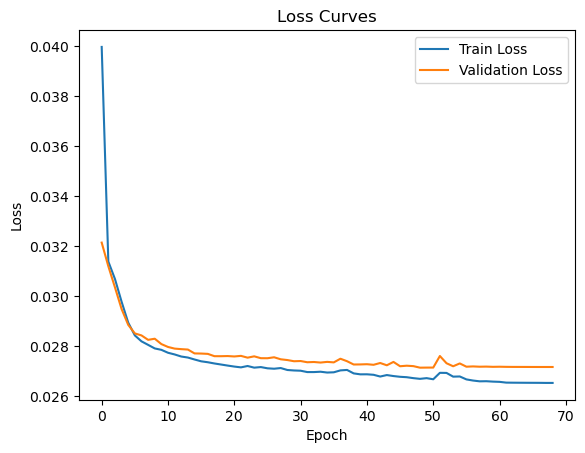

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


dim: 4
Early stopping at epoch 116


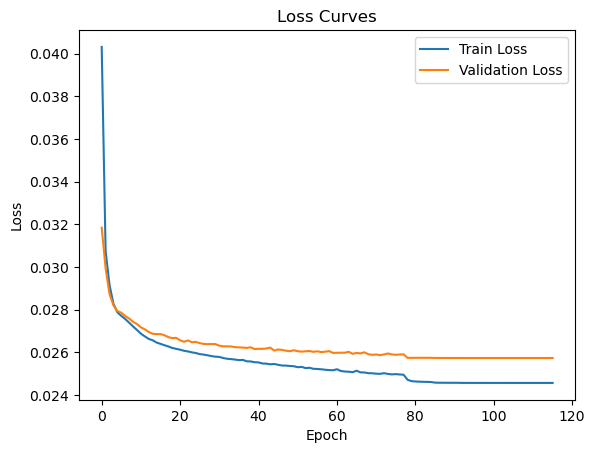

dim: 5


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 217


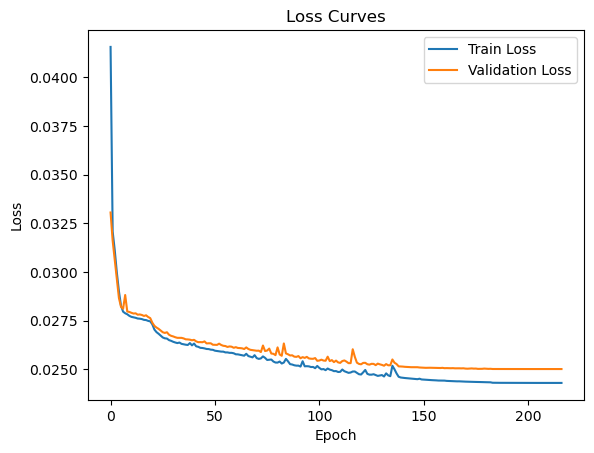

dim: 6


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 112


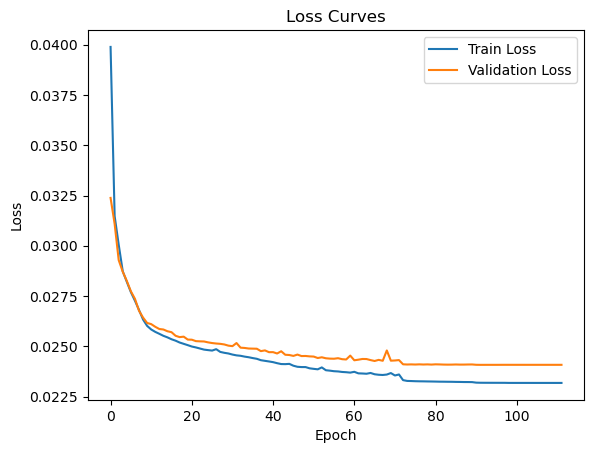

dim: 7


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 95


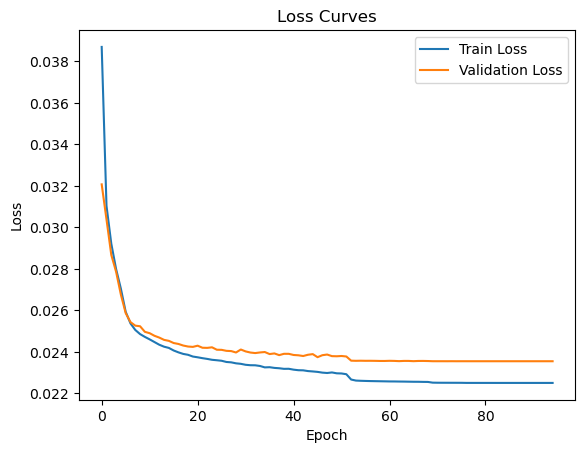

dim: 8


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 102


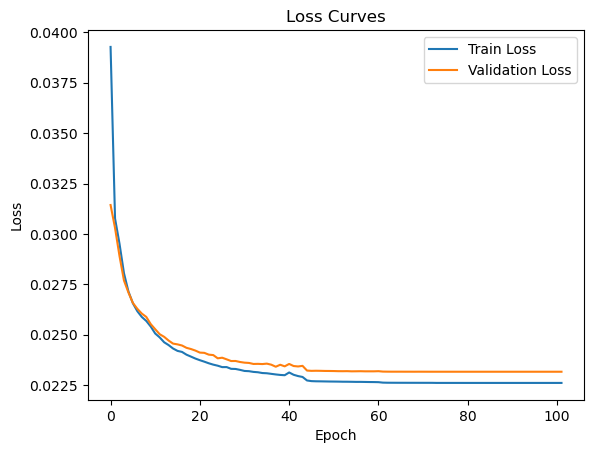

dim: 9


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 845


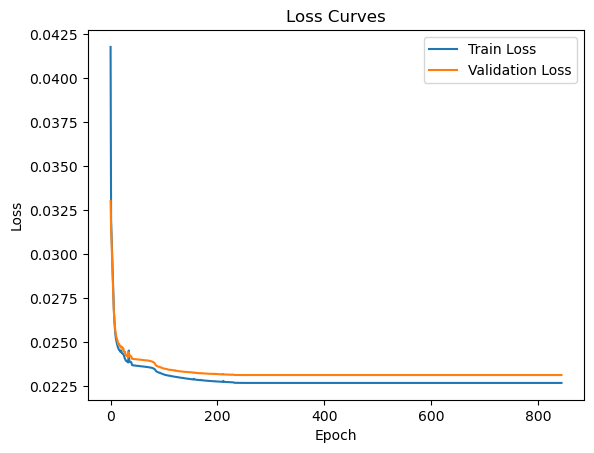

  dim  Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  Factor_7  \
0   3  0.128577  0.037139  0.083654       NaN       NaN       NaN       NaN   
1   4  0.039404  0.070265  0.067627  0.088928       NaN       NaN       NaN   
2   5  0.753936  0.778371  0.730250  0.448976  0.752296       NaN       NaN   
3   6  0.079872  0.109769  0.144014  0.118663  0.093708  0.103968       NaN   
4   7  0.049648  0.073014  0.061288  0.027833  0.048209  0.061344  0.071407   
5   8  0.064883  0.073688  0.074923  0.088808  0.141252  0.093431  0.095356   
6   9  0.102065  0.705459  1.115132  0.246049  1.738985  0.603229  0.374417   

   Factor_8  Factor_9 Factor_10  Total variance ratio  
0       NaN       NaN      None              0.335478  
1       NaN       NaN      None              0.381545  
2       NaN       NaN      None              0.391614  
3       NaN       NaN      None              0.417553  
4       NaN       NaN      None              0.434191  
5  0.068787       NaN      None

C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_16552\134811948.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


In [4]:
# Initialize the DataFrame to store the results
dim_df = pd.DataFrame(
    columns=["dim"] + [f"Factor_{i+1}" for i in range(10)] + ["Total variance ratio"]
)

for latent_dim in range(3, 10):
    print("dim:", latent_dim)

    # Initialize and train the autoencoder
    autoencoder = Autoencoder(X_train, X_val, encoding_dim=latent_dim)
    autoencoder.train()

    # Evaluate the autoencoder on the scaled data
    (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
    ) = autoencoder.evaluate_on_data(X_scaled)

    # Create a temporary DataFrame to store the results for the current latent dimension
    temp_df = pd.DataFrame(
        {
            "dim": [latent_dim],  # Current dimension
            **{
                f"Factor_{i+1}": ratio
                for i, ratio in enumerate(explained_variance_ratios)
            },
            "Total variance ratio": [explained_variance_ratio_total],
        }
    )

    # Fill missing factor columns with NaN to maintain consistent column names
    for col in dim_df.columns:
        if col not in temp_df.columns:
            temp_df[col] = None  # Fill with NaN

    # Sort columns to match the order in dim_df
    temp_df = temp_df[dim_df.columns]

    # Concatenate the temporary DataFrame with the main DataFrame
    dim_df = pd.concat([dim_df, temp_df], ignore_index=True)

print(dim_df)